In [20]:
# Dataset: Cell Body Segmentation
# Source: Hill, LaPan, Li and Haney (2007). Impact of image segmentation 
# on high-content screening data quality for SK-BR-3 cells, BMC 
# Bioinformatics, Vol. 8, pg. 340
# URL: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-8-340
# Description: Hill, LaPan, Li and Haney (2007) develop models to predict 
# which cells in a high content screen were well segmented. The data 
# consists of 119 imaging measurements on 2019. 
# The original analysis used 1009 for training and 1010 as a test set. 
# The outcome class is contained in a factor variable called Class with 
# levels "PS" for poorly segmented and "WS" for well segmented.

#Step 0
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [3]:
#Step 1: Load Data
df_raw = pd.read_csv('../data/raw/skbr_cells.csv')

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 61 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Cell                     2019 non-null   int64  
 1   Case                     2019 non-null   object 
 2   Class                    2019 non-null   object 
 3   AngleCh1                 2019 non-null   float64
 4   AreaCh1                  2019 non-null   int64  
 5   AvgIntenCh1              2019 non-null   float64
 6   AvgIntenCh2              2019 non-null   float64
 7   AvgIntenCh3              2019 non-null   float64
 8   AvgIntenCh4              2019 non-null   float64
 9   ConvexHullAreaRatioCh1   2019 non-null   float64
 10  ConvexHullPerimRatioCh1  2019 non-null   float64
 11  DiffIntenDensityCh1      2019 non-null   float64
 12  DiffIntenDensityCh3      2019 non-null   float64
 13  DiffIntenDensityCh4      2019 non-null   float64
 14  EntropyIntenCh1         

In [4]:
df_raw.sample(10, random_state=1950)

,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
1637,208335120,Train,PS,35.946188,293,49.732143,326.489286,21.157143,150.057143,1.050260,...,13925,91138,5924,42016,23.955831,29.978748,149.035723,19.562161,91,297
593,208316746,Train,WS,84.444671,229,219.000000,331.365297,102.826484,201.095890,1.037611,...,47961,72351,22519,44040,118.721538,191.576486,118.939818,13.544347,274,107
1982,208929318,Train,PS,124.390606,165,18.120253,2.759494,34.063291,49.683544,1.267647,...,2863,279,5382,7850,13.492782,40.563075,53.199777,16.454195,258,431
466,208397499,Train,PS,178.263964,464,53.200903,5.674944,78.489842,1.866817,1.332977,...,23568,2072,34771,827,64.711185,154.649292,2.519066,13.675609,381,376
861,208399848,Train,WS,52.164706,204,100.117949,397.164103,18.605128,149.830769,1.051980,...,19523,77253,3628,29217,46.075873,38.436801,142.602899,16.344128,241,211
855,208336816,Train,PS,82.247234,188,30.394444,3.061111,76.166667,8.405556,1.101333,...,5471,372,13710,1513,21.158003,50.162126,14.950175,10.649279,308,119
1589,208336844,Train,PS,83.993152,228,51.954128,225.807339,50.903670,97.958716,1.088332,...,11326,49009,11097,21355,29.616783,61.975542,91.417899,18.541665,29,196
1591,208341329,Train,PS,129.396930,213,99.250000,2.656863,265.828431,1.637255,1.438356,...,20247,339,54229,334,61.213875,160.905206,7.565128,12.517303,329,295
1281,208322195,Test,PS,79.971064,393,46.592000,169.530667,88.418667,69.330667,1.364899,...,17472,63200,33157,25999,39.645179,79.688849,68.986743,20.053071,423,228
432,208397464,Train,PS,165.895120,237,52.801762,2.008811,132.493392,64.251101,1.368640,...,11986,230,30076,14585,40.879218,97.168339,83.914386,16.880030,269,289


In [5]:
df_train = df_raw[df_raw.Case == 'Train'].copy().reset_index(drop=True)
df_test  = df_raw[df_raw.Case == 'Test' ].copy().reset_index(drop=True)


In [8]:
df_train.describe(include='all').T

#Class -> Variable dependiente. Es un dataset desbalanceado

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Cell,1009.0,NaN,NaN,NaN,208401059.674926,267456.289554,207827645.0,208332449.0,208384293.0,208405207.0,210964110.0
Case,1009,1,Train,1009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Class,1009,2,PS,636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AngleCh1,1009.0,NaN,NaN,NaN,91.126408,48.9119,0.030876,54.662403,90.028267,127.851585,179.939323
AreaCh1,1009.0,NaN,NaN,NaN,325.125867,216.555276,150.0,194.0,256.0,376.0,2186.0
...,...,...,...,...,...,...,...,...,...,...,...
VarIntenCh3,1009.0,NaN,NaN,NaN,101.671773,103.313494,0.869253,37.061489,68.131562,124.989922,757.020963
VarIntenCh4,1009.0,NaN,NaN,NaN,119.925714,114.765223,2.440145,47.088774,85.614564,153.276774,913.883494
WidthCh1,1009.0,NaN,NaN,NaN,17.762058,6.256976,6.393216,13.86172,16.344128,20.293907,54.744763
XCentroid,1009.0,NaN,NaN,NaN,266.222002,139.266724,11.0,149.0,271.0,386.0,501.0


Let's suppose we want to create a model to detect if a cell is poorly or 
well segmented. So let's begin with a Logistic Regression Model, that uses 
the following equation:
$$ log(\frac{p}{1-p})=\beta_0 + \beta_1 A + \beta_2 B $$ 
Just to illustrate the point, we will select only two variables: 
EqSphereAreaCh1 (A) and PerimCh1 (B)

In [15]:
df_example = df_train[['EqSphereAreaCh1','PerimCh1','Class']].copy()

In [16]:
#EDA

df_example.describe().T

,count,mean,std,min,25%,50%,75%,max
EqSphereAreaCh1,1009.0,1302.49725,866.220998,603.755102,779.850340,1027.222222,1505.195011,8746.063492
PerimCh1,1009.0,91.60682,41.962245,47.737594,64.366964,79.021475,103.241588,459.765378


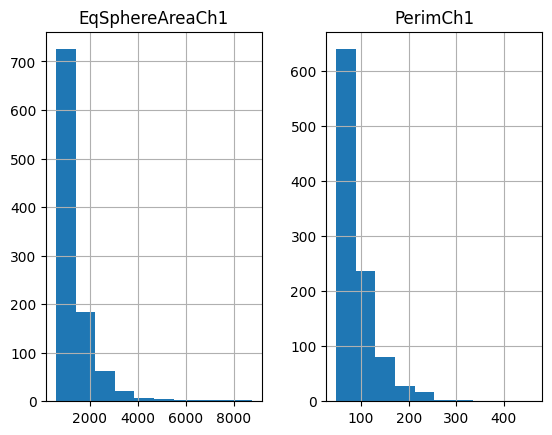

In [17]:
df_example.hist() #analisis univariado
plt.show()

/home/arnaldoch/Documents/Bootcamp_Data_Science/Clases/feature_engineering/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arnaldoch/Documents/Bootcamp_Data_Science/Clases/feature_engineering/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arnaldoch/Documents/Bootcamp_Data_Science/Clases/feature_engineering/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arnaldoch/Documents/Bootc

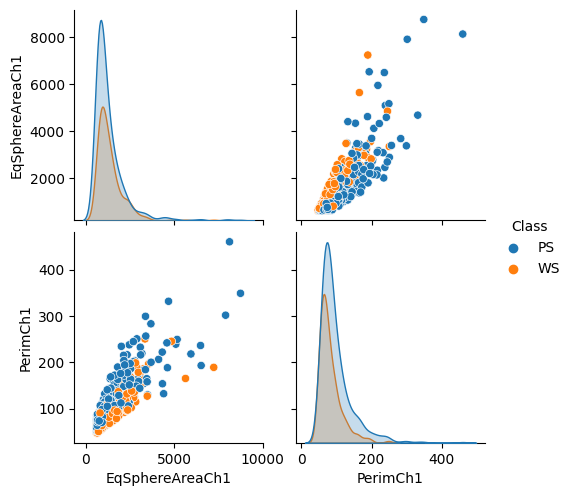

In [18]:
sns.pairplot(data=df_example, hue='Class')
plt.show()

In [19]:
#Step 3: Model Training
X_train = df_example.drop('Class', axis=1).copy()
y_train = df_example['Class'].copy()
X_test = df_test[['EqSphereAreaCh1','PerimCh1']].copy()
y_test = df_test['Class']

In [21]:
model = LogisticRegression(class_weight='balanced')

model.fit(X_train, y_train)

y_hat = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_hat):.3f}')

Accuracy: 0.699


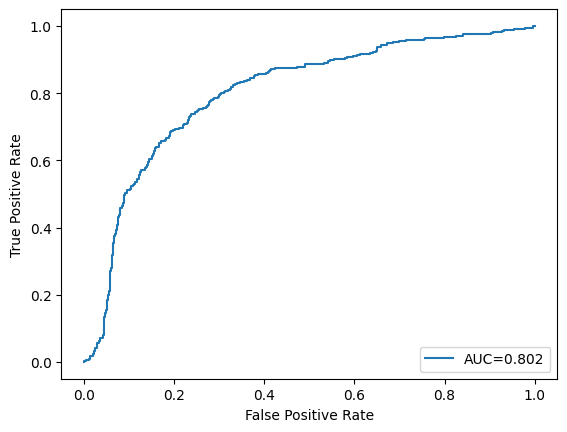

In [24]:
y_hat_proba = model.predict_proba(X_test)[::,1]

fpr, tpr, _ = roc_curve(y_test, y_hat_proba, pos_label='WS')

auc = round(roc_auc_score(y_test, y_hat_proba), 3)

plt.plot(fpr, tpr, label='AUC='+str(auc))

plt.ylabel('True Positive Rate')

plt.xlabel('False Positive Rate')

plt.legend(loc=4)

plt.show()

In [25]:
power_transformer = PowerTransformer() #PowerTransformer busca un coeficiente de tal manera que pueda hacerse lo mas simetrica posible

X_train_tr = power_transformer.fit_transform(X_train)

X_test_tr = power_transformer.transform(X_test)

model_tr = LogisticRegression(class_weight='balanced')

model_tr.fit(X_train_tr, y_train)

y_hat_tr = model_tr.predict(X_test_tr)

print(f'Accuracy Transformed: {accuracy_score(y_test, y_hat_tr):.3f}')

Accuracy Transformed: 0.744


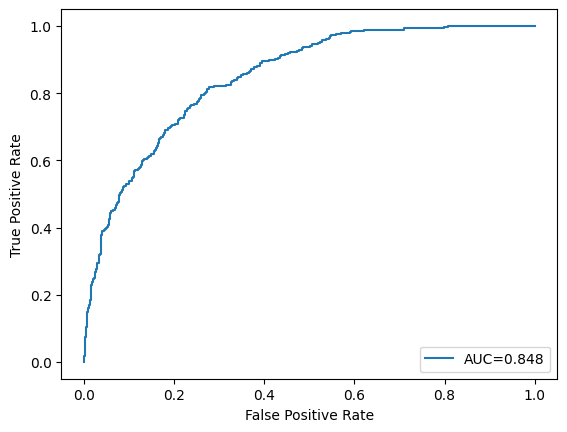

In [26]:
y_hat_proba_tr = model_tr.predict_proba(X_test_tr)[::,1]

fpr_tr, tpr_tr, _ = roc_curve(y_test, y_hat_proba_tr, pos_label='WS')

auc_tr = round(roc_auc_score(y_test, y_hat_proba_tr), 3)

plt.plot(fpr_tr, tpr_tr, label='AUC='+str(auc_tr))

plt.ylabel('True Positive Rate')

plt.xlabel('False Positive Rate')

plt.legend(loc=4)

plt.show()

In [27]:
df_example_tr = pd.DataFrame(data=X_train_tr, columns=X_train.columns)

df_example_tr['Class'] = y_train



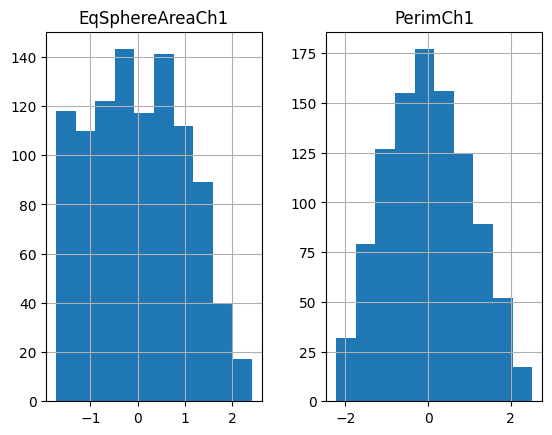

In [28]:
df_example_tr.hist()

plt.show()

/home/arnaldoch/Documents/Bootcamp_Data_Science/Clases/feature_engineering/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arnaldoch/Documents/Bootcamp_Data_Science/Clases/feature_engineering/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arnaldoch/Documents/Bootcamp_Data_Science/Clases/feature_engineering/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/arnaldoch/Documents/Bootc

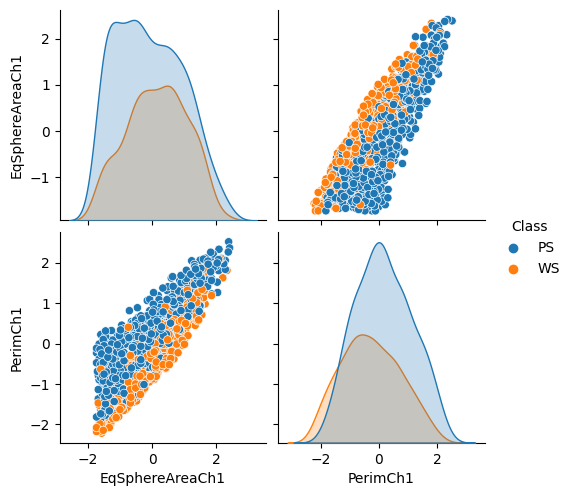

In [29]:
sns.pairplot(data=df_example_tr, hue='Class')

plt.show()